## 1. 사용할 패키지 불러오기

In [1]:
from utils import ConstructDataset, ConstructInferenceDataset, prepare_dataset
from models.visualize import plot_loss, plot_score, plot_acc, visualize_inference
from models import ModelFactory, LossFactory, fit 
from models.inference import get_samples, predict_image_mask_miou, miou_score, pixel_acc
import albumentations as A
from torch.utils.data import DataLoader
from torchvision import transforms as T
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import os
import torch
import torch.nn as nn

/home/jongwook95.lee/miniforge3/envs/torch_segmentation_assets/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. 데이터셋 불러오기

### (1) Dataset Directory Setting

In [2]:
train_image_dir = './dataset/train/JPEGImages'
test_image_dir = './dataset/test/JPEGImages'

train_mask_dir = './dataset/train/SegmentationClass'
test_mask_dir = './dataset/test/SegmentationClass'

### (2) Prepare Dataset

In [3]:
train_dataset = prepare_dataset(image_dir = train_image_dir, mask_dir = train_mask_dir)
test_dataset = prepare_dataset(image_dir = test_image_dir, mask_dir = test_mask_dir, label_exist = True)

The number of image files: 2909
The number of mask files: 2909
The number of image files: 4
The number of mask files: 4


### (3) Train Dataset으로 부터 Validation Dataset 생성

In [4]:
valid_split = 0.2

In [5]:
train_image_list, valid_image_list, train_mask_list, valid_mask_list = train_test_split(train_dataset['Image'], train_dataset['Mask'], test_size=valid_split, random_state=1004)
test_image_list = test_dataset['Image']
test_mask_list = test_dataset['Mask']

## 3. Parameter Setting

### (1) Transformation Setting

In [6]:
input_size = (384, 512)  # devided by 32
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [7]:
train_transform = A.Compose([A.Resize(input_size[0], input_size[1], interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

validation_transform = A.Compose([A.Resize(input_size[0], input_size[1], interpolation=cv2.INTER_NEAREST)])

### (2) Make Torch DataLoader

In [8]:
batch_size = 16

In [9]:
train_set = ConstructDataset(train_image_list, train_mask_list, mean, std, train_transform)
val_set = ConstructDataset(valid_image_list, valid_mask_list, mean, std, validation_transform)

In [10]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)     

## 4. Model

### (1) Parameter Setting

In [20]:
architecture = 'DeepLabV3Plus' ## ['unet', 'fpn', 'DeepLabV3Plus']
encoder_name = 'mobilenet_v2'
in_channels = 3
class_num = 22
experiment_path = './result'
os.makedirs(experiment_path, exist_ok=True)
os.makedirs(os.path.join(experiment_path, architecture + '+' + encoder_name), exist_ok=True)
save_model_path = os.path.join(experiment_path, architecture + '+' + encoder_name)


### (2) Construct Model

In [21]:
model = ModelFactory(architecture = architecture, encoder_name = encoder_name, in_channels = in_channels, class_num = class_num)

## 5. Training

### (1) Loss, Optimizer 정의

In [22]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = LossFactory(loss_name = 'crossentropy').get_loss_fn()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))

### (2) Fit

In [23]:
history = fit(epoch, model, train_dataloader, valid_dataloader, criterion, optimizer, sched, save_model_path, device)

  0%|          | 0/146 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 11.91 GiB total capacity; 486.97 MiB already allocated; 61.81 MiB free; 498.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### (3) Plot Training Process

In [13]:
plot_loss(history)
plot_score(history)
plot_acc(history)

NameError: name 'history' is not defined

### (4) Load Best model

In [14]:
best_model = torch.load(os.path.join(save_model_path, 'best_model.pt'))

## 6. Inference

### (1) Construct Inference Dataset

In [15]:
test_set = ConstructInferenceDataset(valid_image_list, valid_mask_list, validation_transform)

### (2) Sample Testset Visualize

In [16]:
sample_testset = get_samples(test_set, 5)

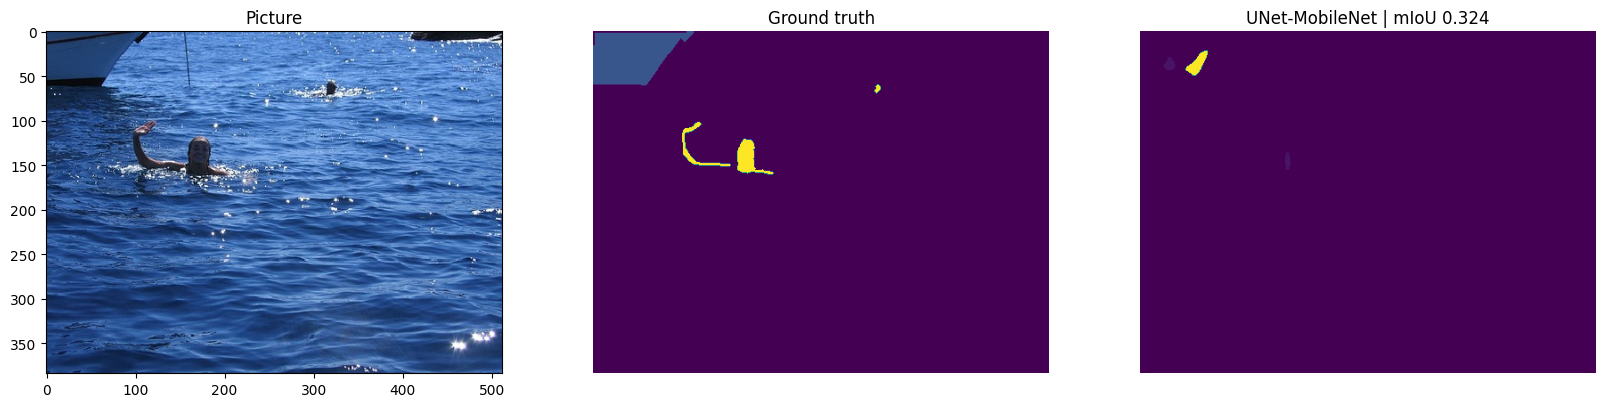

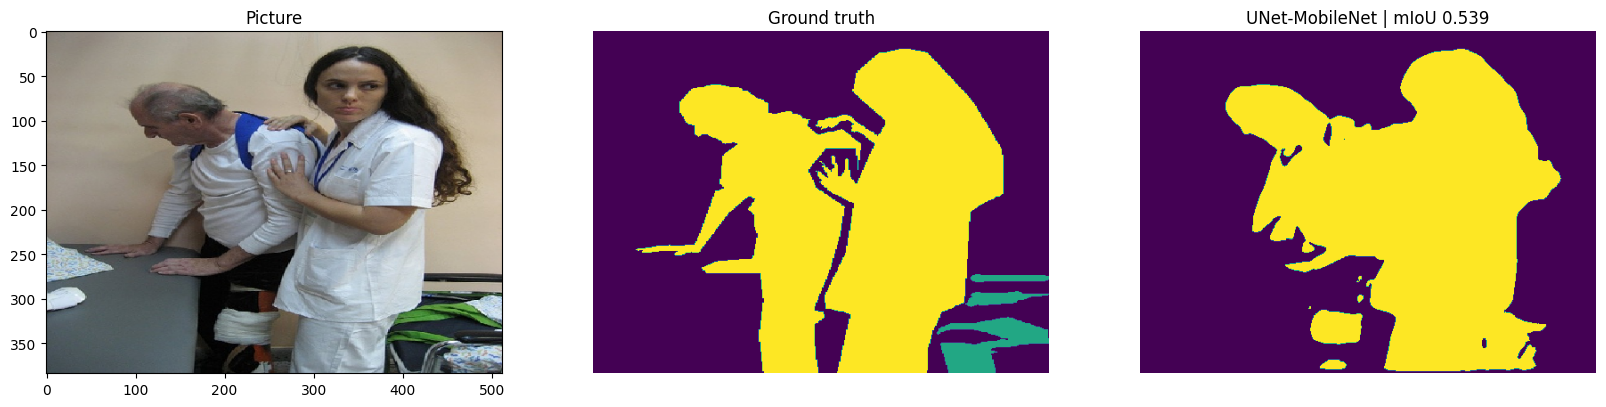

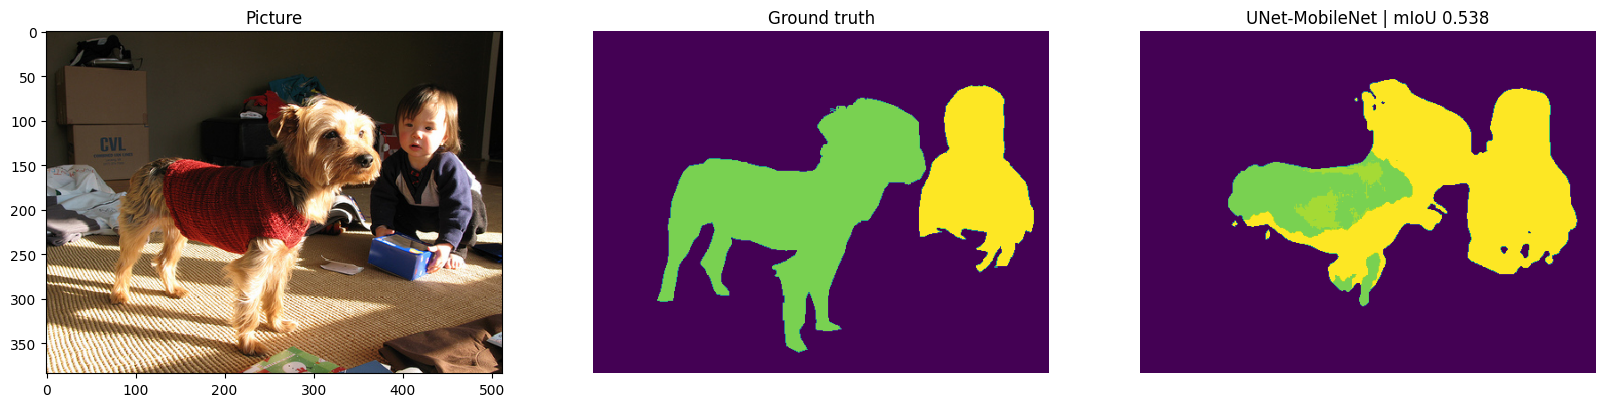

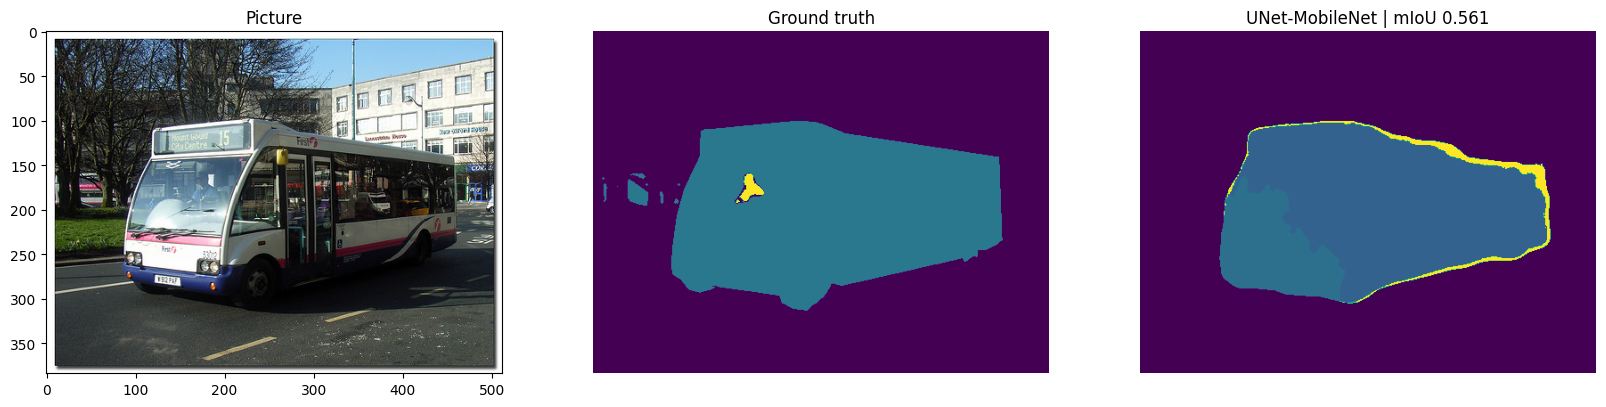

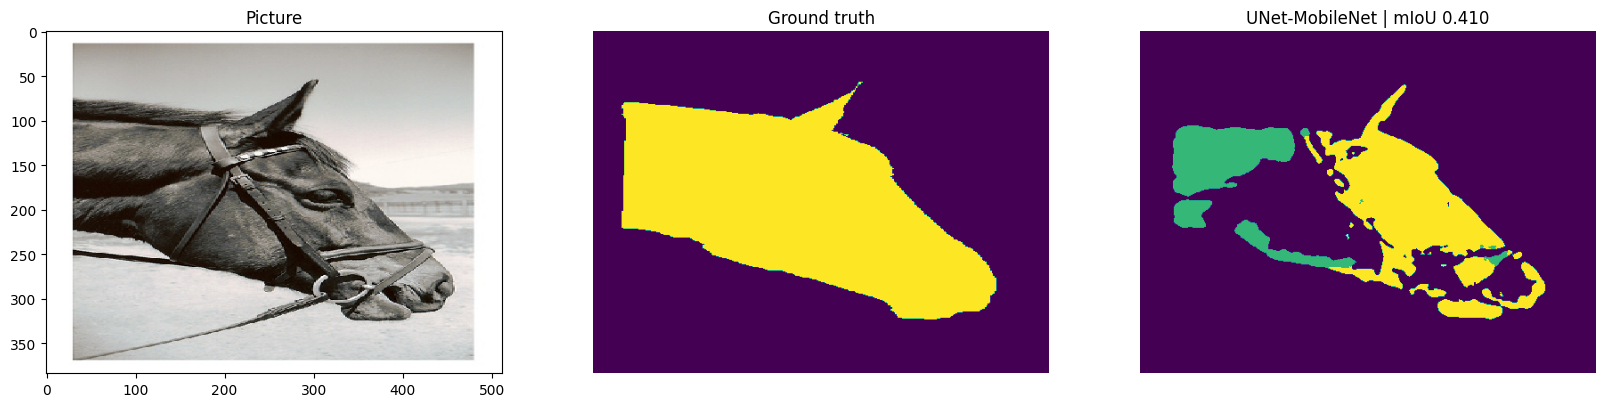

In [17]:
for (image, mask) in sample_testset:
    pred_mask, score = predict_image_mask_miou(best_model, image, mask, device)
    visualize_inference(image, mask, pred_mask, architecture = architecture, encoder_name = encoder_name, score = score)

### (3) Performance

In [24]:
mob_miou = miou_score(model, test_set, device)
print('Test Set mIoU', np.mean(mob_miou))

  0%|          | 0/582 [00:00<?, ?it/s]


TypeError: predict_image_mask_miou() missing 1 required positional argument: 'device'

In [ ]:
mob_acc = pixel_acc(model, test_set, device)
print('Test Set Pixel Accuracy', np.mean(mob_acc))